In [34]:
from os import path as osp

def harvest_info(folder):
    'Get information about images, from gdalinfo output'
    info = {}
    with open(folder + "info.txt", "r") as f:
        for line in f:
            # Look for the file name
            if "Files: " not in line:
                continue
            finfo = {}
            # Strip the start and the end
            line = line[7:].strip()
            # Remove extension
            line = osp.splitext(line)[0]
            finfo['name'] = line
            while line and "Driver:" not in line:
                try:
                    line = next(f)
                except StopIteration:
                    break
                if line.startswith("Size is "):
                    # Trim the begining
                    line = line[8:]
                    # Split the line
                    parts = line.split(",")
                    finfo['width'] = int(parts[0])
                    finfo['height'] = int(parts[1])
                # How many bands
                if line.startswith("Band "):
                    # Get the band number
                    band = int(line[5:].split(" ")[0])
                    finfo['bands'] = band
                # Get the data type
                if line.startswith("Band 1"):
                    # Skip to "Type="
                    if line[line.find("Type="):].startswith("Type=UInt16"):
                        finfo['data_type'] = "UInt16"
                    else:
                        finfo['data_type'] = "UInt8"

            info[finfo['name']] = finfo
    
    return info

def get_info(name, infos):
    'Get information about a specific image'
    if name in infos:
        return infos[name]
    return None


In [35]:
# Look at the files, create a csv file with the size of the files

# main_path is where the files are stored

# Image collection from https://imagecompression.info/test_images/, RGB 8bit linear
# 14 large photographs (1 rendered), image size varies
# QB3 fast savings: -3097889 -1.34%
# QB3 base savings: -2871001 -1.24%
# QB3 best: -2461457 -1.06%
# QB3 best band mix savings: 544224 0.235%
# QB3 best band mix +zstd saving: 4305454 1.856%
# Total Qb3 output: 98.14% of the PNGs
#
# Not great, even and zstd doesn't help much. Dificult, noisy images
# But the size increate with QB3 is very small. big_building saves the day
#
# main_path = "/data/imagecompression.info/rgb8bit/"

# Image collection from https://imagecompression.info/test_images/, RGB 16bit linear
# 14 large photographs (1 rendered), image size varies
# QB3 fast savings: 66510870 8.87%
# QB3 base savings: 66766111 8.91%
# QB3 best: 69214533 9.23%
# QB3 best band mix savings: 76852479 10.3%
# QB3 best band mix +zstd saving: 78486247 10.47%
# Total Qb3 output: 89.53% of the PNGs
# 
# This is the same images as the 8bit collection, the extra bit depth helps QB3
# QB3 is very good for 16 bit natural images, saving 9-10%
# Adding zstd doesn't help much
# "artificial" image is what drags QB3 down, since there are lots of flat areas which work great in PNG
# "fireworks" is noisy, but chaning the colors to 1,1,2 helps
#
# main_path = "/data/imagecompression.info/rgb16bit/"

# Kodak Image Collection, 24 images, 768x512, 24bit RGB
# All natural images
# 
# Total size of input PNGs: 15940416, 56.3036% of raw
# QB3 fast savings: 2542210 15.9%
# QB3 base savings: 2556343 16.0%
# QB3 best: 2597731 16.3%
# QB3 best band mix savings: 2618258 16.4%
# QB3 best band mix +zstd saving: 3054131 19.16%
# Total Qb3 output: 80.84% of the PNGs, 45.516% of raw
#
# QB3 is very good for this collection, better than PNG for all inputs
# saving 16-17% without zstd
# 
# main_path = "/data/kodim/"

# Image collection described in https://siipo.la/blog/whats-the-best-lossless-image-format-comparing-png-webp-avif-and-jpeg-xl
# Mostly digital art, which doesn't work that well with qb3
# Total size of input PNGs: 27325539
# QB3 fast savings: -4184486 -15.3%
# QB3 base savings: -4124190 -15.1%
# QB3 best: -1743935 -6.38%
# QB3 best band mix savings: -1426775 -5.22%
# QB3 best band mix +zstd saving: 3555957 13.01%
# Total Qb3 output: 86.99% of the PNGs
# 
# QB3 is not great for this collection, adding zstd helps a lot (digital art)
#
# main_path = "/data/images.siipo.la/"

# Image collection from https://cloudinary.com/labs/cid22, the 250 source images
# Consistent 512x512 RGB 8bit images, mostly photographs with a few digital images
# There are two grayscale images, the 2387532 and 962312
# Those have been converted to RGB by duplicating the channel values, to
# ensure that the compression ratios are identical based on the number of raq bytes
# This hurts PNG a lot more than QB3 because of the band decorrelaton
#
# 962312.png grayscale 110069, color 223317
# 2387532.png grayscale 96741, color 166959
#
# Even when keeping it grayscale, QB3 wins on the 2387532 image
# To simplify, those two images are not included in the analysis
#
# Total size of input PNGs: 90821437, 46.1942% of raw
# QB3 fast savings: 6376318 7.02%
# QB3 base savings: 6491013 7.15%
# QB3 best: 6864481 7.56%
# QB3 best band mix savings: 7603497 8.37%
# QB3 best band mix +zstd saving: 10627333 11.7%
# Total QB3 output: 88.3% of the PNGs
# QB3 40.7888% of raw
#
# Total size of input PNGs: 90431161, 46.3666% of raw
# QB3 fast savings: 6219876 6.88%
# QB3 base savings: 6334365 7.0%
# QB3 best: 6706606 7.42%
# QB3 best band mix savings: 7445604 8.23%
# QB3 best band mix +zstd saving: 10450694 11.56%
# Total QB3 output: 88.44% of the PNGs
# QB3 41.0082% of raw
#
# There isn't much difference between QB3 modes, but they are all better than PNG, 
# saving 7-8%. Adding zstd (default, level 3) increases the savings to 11.56%
#
main_path = "/data/CID22/"

dataset_name = "CID22" if "CID22" in main_path else "Kodim" if "kodim" in main_path \
    else "Siipo" if "siipo" in main_path else "Unknown"

# Path to redone pngs, using standar zlib and libpng at level6
# This eliminates the variations on the PNGs
orig_path = main_path + "redo/"

infos = None
try:
    infos = harvest_info(main_path)
    print(f"Got info for {len(infos)} images")
except FileNotFoundError:
    pass

# QB3 in FTL mode
qb3_fast_path = main_path + "qb3/"
# QB3 in BASE mode
qb3_base_path = main_path + "qb3d/"
# QB3 in BEST mode
qb3_best_path = main_path + "qb3b/"
# QB3 in BEST mode with best band mix
qb3_best_band_path = main_path + "qb3bx/"
# QB3 in BEST MX mode + zstd
qb3_fast_zstd_path = main_path + "qb3z/"

import csv

# First, get the list of redone files
import os
from os import path as path

orig_files = os.listdir(orig_path)
# Now, get the size of the files
orig_sizes = []
qb3fast_sizes = []
qb3base_sizes = []
qb3best_sizes = []
qb3best_band_sizes = []
qb3z = []

names = []
for f in orig_files:
    if "png" in f:
        bane = path.splitext(f)[0]
        names.append(bane)
        orig_sizes.append(path.getsize(orig_path + f))
        qb3fast_sizes.append(path.getsize(qb3_fast_path + bane + ".qb3"))
        qb3base_sizes.append(path.getsize(qb3_base_path + bane + ".qb3"))
        qb3best_sizes.append(path.getsize(qb3_best_path + bane + ".qb3"))
        qb3best_band_sizes.append(path.getsize(qb3_best_band_path + bane + ".qb3"))
        qb3z.append(path.getsize(qb3_fast_zstd_path + bane + ".qbz"))

# Zip the lists
data = zip(names, orig_sizes, qb3fast_sizes, qb3base_sizes, 
           qb3best_sizes, qb3best_band_sizes, qb3z)
# Sort list by original size
data = sorted(data, key=lambda x: x[1])

# Write the data to a csv file, with LF line endings
with open("CID22_sizes.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    labels = ["Name", "PNG", "QB3 Fast", "QB3 Base", 
                     "QB3 Best", "QB3 Best Band", "QB3 + Zstd"]
    writer.writerow(labels)
    for d in data:
        writer.writerow(d)

def read_csv(filename):
    with open(filename, "r") as f:
        reader = csv.reader(f)
        labels = next(reader)
        data = list(reader)

    # Convert size columns to integers
    for j in range(len(data)):
        for i in range(1, len(labels)):
            data[j][i] = int(data[j][i])

    return labels, data

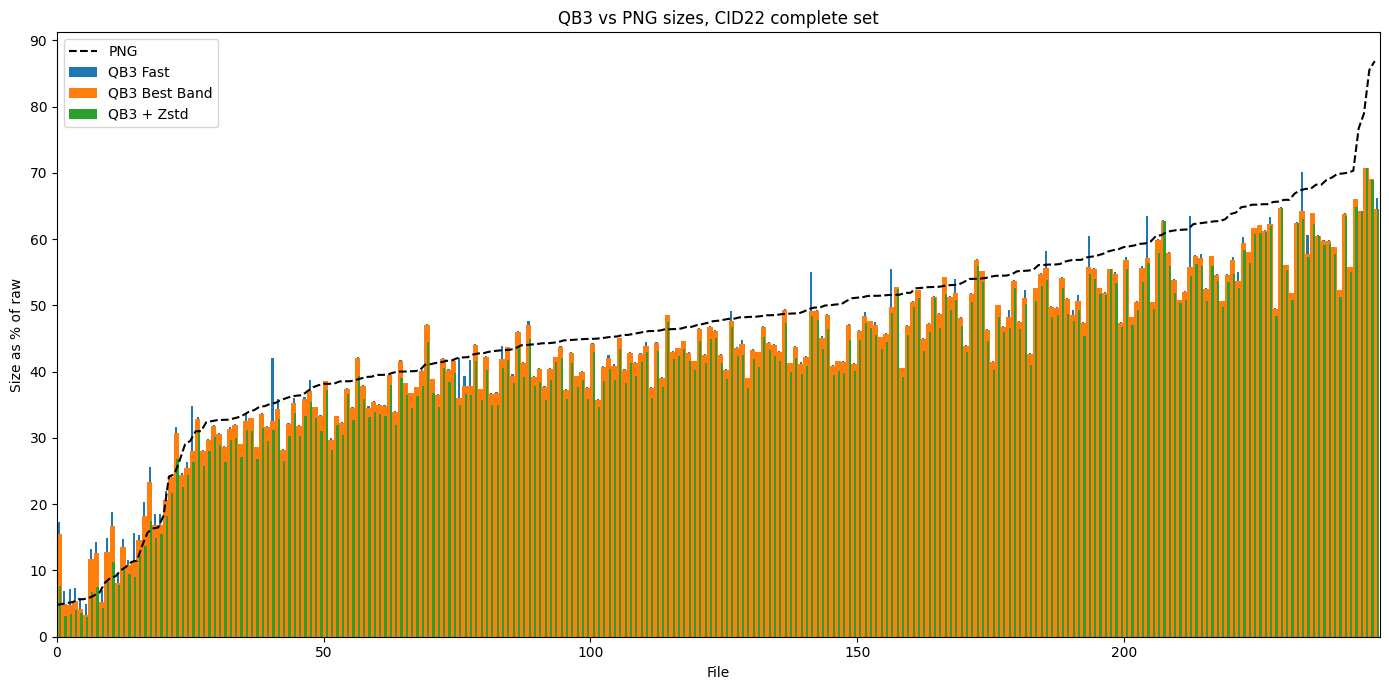

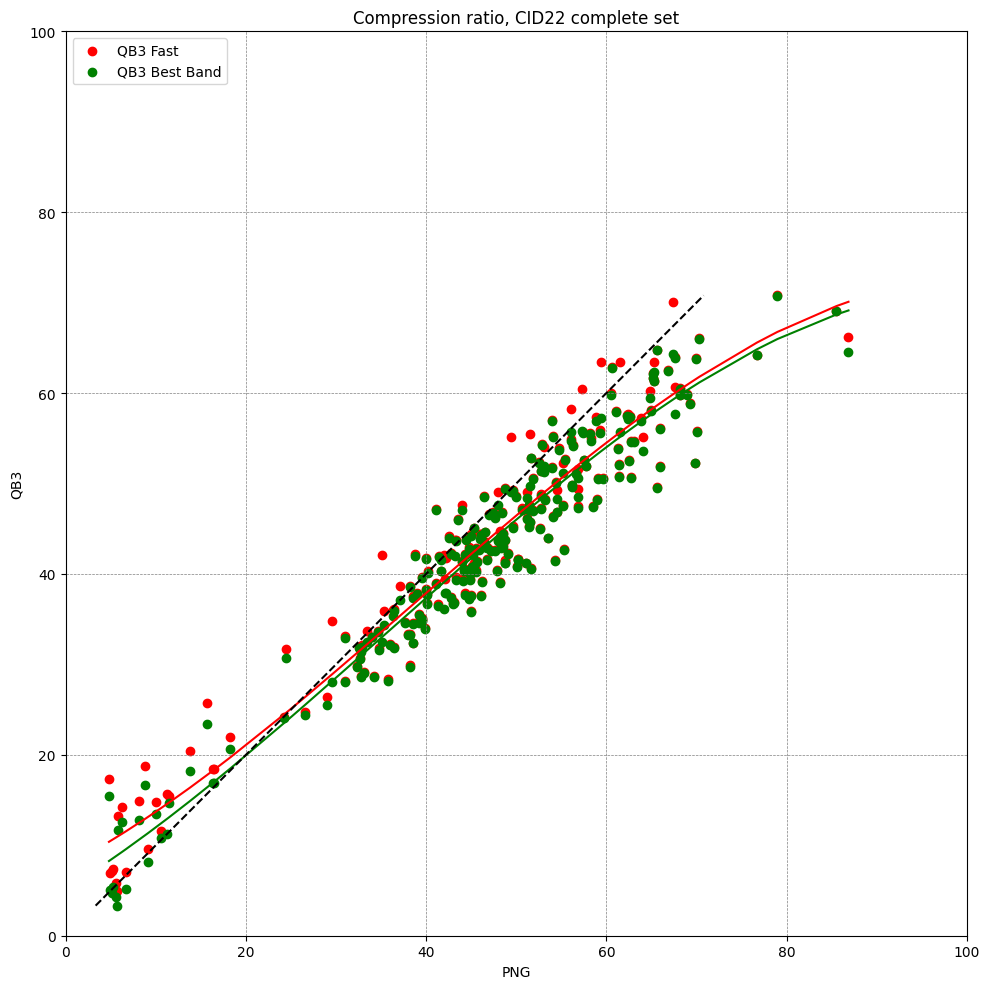

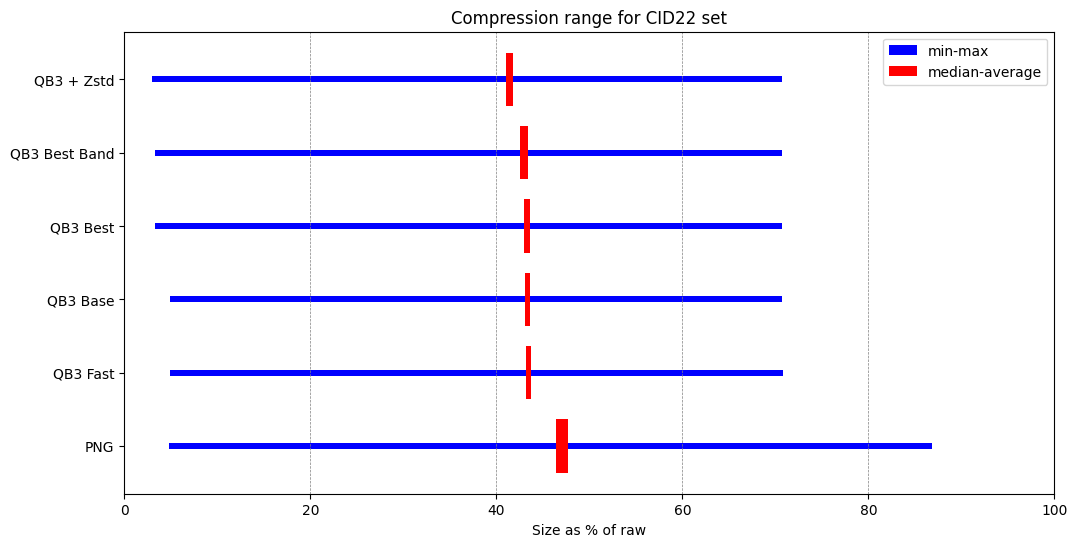

In [36]:
# plot the data as bar chart, sorted by PNG size
import matplotlib.pyplot as plt
import numpy as np

# Create a figure
fig, ax = plt.subplots()
# Set the figure size
fig.set_size_inches(14, 7)

# Create a bar plot for 4 bars, one space between each
bar_width = 0.2

# Read the CSV file to plot
labels, data = read_csv("CID22_sizes.csv")
index = np.arange(len(data))

# Unpack by columns
names = [x[0] for x in data]
# Normalize to percentage of raw size if the set is known
RAW_SIZE = 1
# KODIM set is 768x512
if "kodim" in main_path:
    RAW_SIZE = 768*512*3 / 100
elif "CID22" in main_path:
    RAW_SIZE = 512*512*3 / 100
lines = [[x[col]/RAW_SIZE for x in data] for col in range(1, len(labels))]

# If we have info and RAW_SIZE is 1, convert all sizes normalized to 100
if infos and RAW_SIZE == 1:
    RAW_SIZE = 100
    lines = [[RAW_SIZE * x[col]/(infos[x[0]]['width']*infos[x[0]]['height']*infos[x[0]]['bands'] * (
        2 if infos[x[0]]['data_type'] == "UInt16" else 1
    )) for x in data]
             for col in range(1, len(labels))]
    # Transpose the list
    lines = list(map(list, zip(*lines)))
    # Sort the list by the first column
    lines = sorted(lines, key=lambda x: x[0])
    # Transpose back
    lines = list(map(list, zip(*lines)))
elif RAW_SIZE == 1:
    print("No info, not normalizing")

# Make the original a line, with no marker
plt.plot(index, lines[0], label="PNG", linestyle='--', color='black')
plt.bar(index + 2*bar_width, lines[1], bar_width*2, label=labels[2])
# bar_qb3base = plt.bar(index + 2*bar_width, lines[2], bar_width, label=labels[3])
# bar_qb3best = plt.bar(index + 3*bar_width, lines[3], bar_width, label=labels[4])
plt.bar(index + 2*bar_width, lines[4], bar_width*5, label=labels[5])
plt.bar(index + 3*bar_width, lines[5], bar_width*2, label=labels[6])

plt.xlabel("File")
# Place x = 0 on the extreme left
plt.xlim(0, len(data))

plt.ylabel("Size as % of raw")
plt.yticks(np.arange(0, 100, 10))
    
plt.title(f"QB3 vs PNG sizes, {dataset_name} complete set")
# plt.xticks(index + bar_width, names, rotation=70)
# Legend, upper left
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
# Save the figure
fig.savefig("CID22_QB3vsPNG.svg")

# Another figure, same data, as scatter plot between PNGs and QB3
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
# Draw a grid, at every 20% intervals
# Range is 100 x 100
plt.xlim((0, 100))
plt.ylim((0, 100))
plt.grid(which='major', axis='both', linestyle='--', color='gray', linewidth=0.5)

colors = ['', 'red', 'blue', 'green', 'green', 'blue']
mins = []
maxs = []
for c in 1, 4:
    color=colors[c]
    mins.append(np.min(lines[c]))
    maxs.append(np.max(lines[c]))
    plt.scatter(lines[0], lines[c], label = labels[c + 1], color=color)
    # Add trend line
    z = np.polyfit(lines[0], lines[c], 3)
    p = np.poly1d(z)
    plt.plot(lines[0], p(lines[0]), color=color)
minv = min(mins)
maxv = max(maxs)

plt.xlabel("PNG")
plt.ylabel("QB3")
plt.title(f"Compression ratio, {dataset_name} complete set")
plt.legend(loc='upper left')

# Plot the 1:1 line, only works in normalized data
ends = [minv, maxv]
plt.plot(ends, ends, color='black', linestyle='--')
plt.tight_layout()
plt.show()

# Compute the min, max and median percentage
compression = []
for i in range(len(lines)):
    minv = np.min(lines[i])
    maxv = np.max(lines[i])
    median = np.median(lines[i])
    average = np.mean(lines[i])
    compression.append([minv, maxv, median, average])
mins, maxs, medians, averages = [[c[i] for c in compression] for i in range(4)]

# Horizontal Candlestick plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 6)

width = .8
count = len(mins)
indices = np.arange(count)

plt.xlim(min(mins) * 0.9, max(maxs) * 1.05)
plt.grid(which='major', axis='x', linestyle='--', color='gray', linewidth=0.5)
plt.xlim(0, 100)
plt.barh(indices,
         [maxs[i] - mins[i] for i in indices], 
         width/10, 
         left = mins,
         color='blue', label='min-max')
plt.barh(indices,
         [averages[i] - medians[i] for i in indices], 
         width/1.1, 
         left = medians,
         color='red', label='median-average')
# Add the labels
plt.yticks(indices, labels[1:])

plt.xlabel("Size as % of raw")
plt.title(f"Compression range for {dataset_name} set")
plt.legend(loc='upper right')
plt.show()


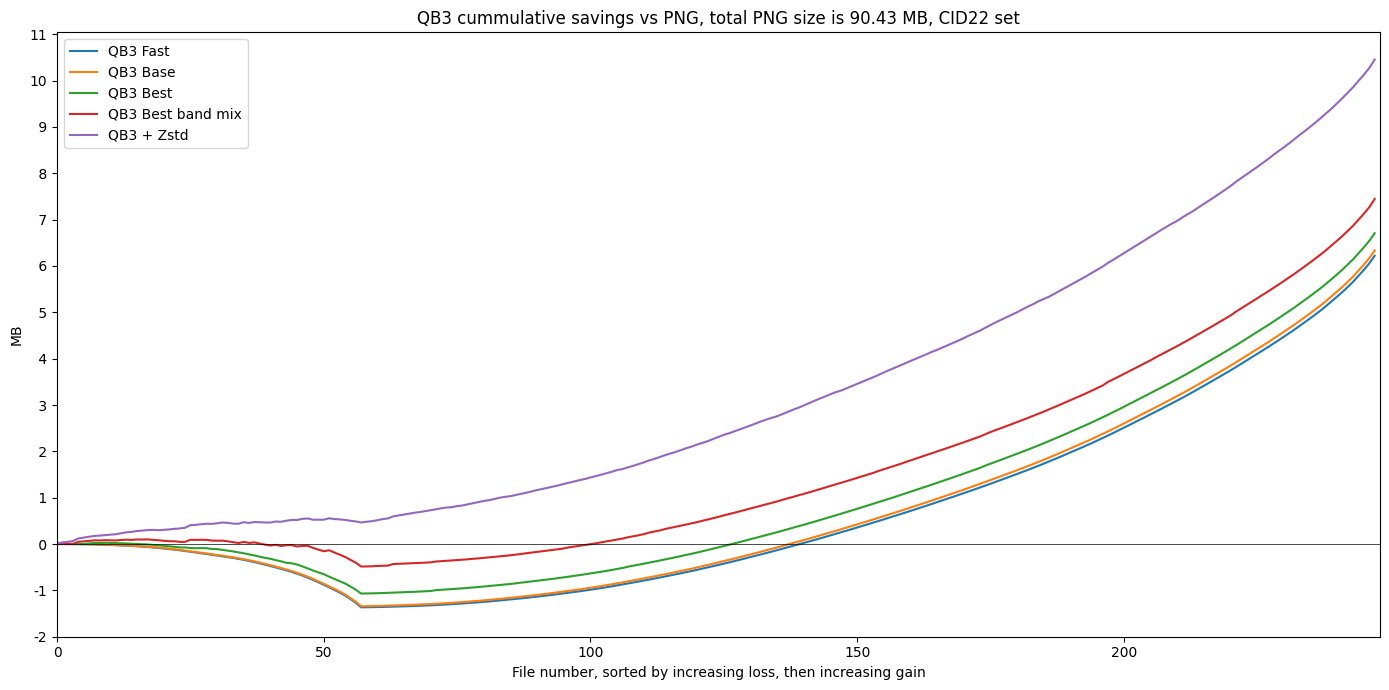

Total size of input PNGs: 90431161, 46.3666% of raw
QB3 fast: 6219876 6.88%
QB3 base: 6334365 7.0%
QB3 best: 6706606 7.42%
QB3 best + band mix: 7445604 8.23%
QB3 best + band mix + zstd: 10450694 11.56%
Total QB3 output: 88.44% of the PNGs
QB3 41.0082% of raw


In [37]:
# Another way to compare the size, based on the difference between the original and the best_band sizes, as a running sum
import matplotlib.pyplot as plt

# First, sort the data by the difference between the original and the best_band sizes
labels, data = read_csv("CID22_sizes.csv")
data = sorted(data, key=lambda x: x[1] - x[2])

data = [[x[0], x[1], x[1] - x[2], x[1] - x[3], x[1] - x[4], x[1] - x[5], x[1] - x[6]] for x in data]

# To make the graph easier to interpret, split the lines into 2 groups, the ones with negative savings and the ones with positive savings on col 2
neg_data = [x for x in data if x[2] < 0]
pos_data = [x for x in data if x[2] >= 0]

# Reverse the negative data, so the lines start from the right
neg_data = neg_data[::-1]
# join them back, prepand a line with 0s
data = [[0, 0, 0, 0, 0, 0, 0]] + neg_data + pos_data

# For columns 2 to 5, replace the values with the running sums, converted to MB
for line in range(1, len(data)):
    for col in range(2, len(data[0])):
        data[line][col] = data[line-1][col] + data[line][col]

# Remove the first line, it was just a placeholder
data = data[1:]

# Let's save this csv
# with open("CID22_savings.csv", "w") as f:
#     writer = csv.writer(f, lineterminator='\n')
#     writer.writerow(labels)
#     for d in data:
#         writer.writerow(d)

# Total size of the PNGs
totalsize = sum(x[1] for x in data)

# Create a figure
fig, ax = plt.subplots()
# Set the figure size
fig.set_size_inches(14,7)

# Create a line chart
index = range(len(data))
# Unpack by columns
names, orig, qb3fast, qb3base, qb3best, qb3bestmix, qb3z = zip(*data)

# line_orig = plt.plot(index, orig, label="Original")
line_qb3fast = plt.plot(index, qb3fast, label="QB3 Fast")
line_qb3base = plt.plot(index, qb3base, label="QB3 Base")
line_qb3best = plt.plot(index, qb3best, label="QB3 Best")
line_qb3bestmix = plt.plot(index, qb3bestmix, label="QB3 Best band mix")
line_qb3z = plt.plot(index, qb3z, label="QB3 + Zstd")

plt.xlabel("File number, sorted by increasing loss, then increasing gain")
plt.ylabel("MB")
plt.title(f"QB3 cummulative savings vs PNG, total PNG size is {totalsize/1e6:2.2f} MB, {dataset_name} set")
# Draw a line at 0, thin
plt.axhline(0, color='black', linewidth=0.5)
# Place x = 0 on the extreme left
plt.xlim(0, len(data))
# Vertical axis ticks every 1e6
plt.yticks(np.arange(-2e6, 12e6, 1e6))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x/1e6:2.0f}"))
# Legend
plt.legend()
plt.tight_layout()
plt.show()
# Save it as SVG
fig.savefig("CID22_savings.svg")

# print the last value vs sum of the first column, in percentage
if "kodim" in main_path or "CID22" in main_path:
    print(f"Total size of input PNGs: {totalsize}, {totalsize/len(data)/RAW_SIZE:2.6}% of raw")
print(f"QB3 fast: {data[-1][2]} {100*data[-1][2]/totalsize:1.3}%")
print(f"QB3 base: {data[-1][3]} {100*data[-1][3]/totalsize:1.3}%")
print(f"QB3 best: {data[-1][4]} {100*data[-1][4]/totalsize:1.3}%")
print(f"QB3 best + band mix: {data[-1][5]} {100*data[-1][5]/totalsize:1.3}%")
print(f"QB3 best + band mix + zstd: {data[-1][6]} {100*data[-1][6]/totalsize:1.4}%")
print(f"Total QB3 output: {100*(totalsize - data[-1][6])/totalsize:2.4}% of the PNGs")
if "kodim" in main_path or "CID22" in main_path:
    print(f"QB3 {(totalsize - data[-1][6])/len(data)/RAW_SIZE:2.6}% of raw")

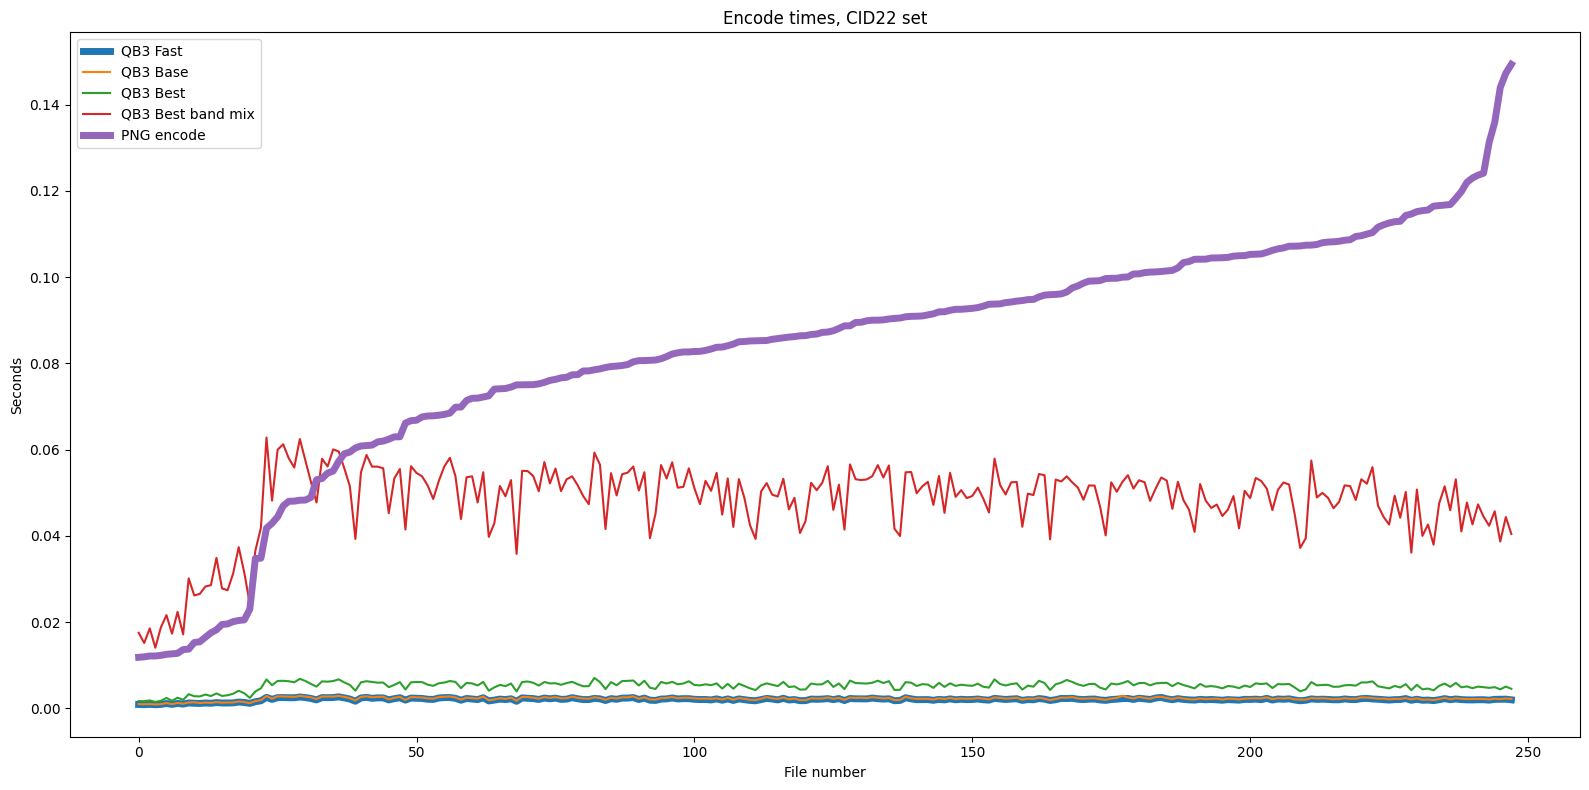

QB3 Fast:
 max 2.69ms,  292.79 MB/s
 avg 2.07ms, 380.59 MB/s
 min 0.87ms,  907.49 MB/s
QB3 Base:
 max 2.93ms,  268.00 MB/s
 avg 2.25ms, 349.11 MB/s
 min 0.93ms,  843.09 MB/s
QB3 Best:
 max 7.07ms,  111.19 MB/s
 avg 5.24ms, 150.00 MB/s
 min 1.50ms,  523.03 MB/s
QB3 Best Band:
 max 62.82ms,  12.52 MB/s
 avg 47.96ms, 16.40 MB/s
 min 14.09ms,  55.82 MB/s
PNG encode average: 82.90ms, 94.86 MB/s


In [ ]:
# Parse cqb3 output, get the figures by file name
import traceback
import matplotlib.pyplot as plt

main_path = "/data/CID22/"
# main_path = "/data/imagecompression.info/rgb16bit/"
dataset_name = "CID22" if "CID22" in main_path else "Kodim" if "kodim" in main_path \
    else "Siipo" if "siipo" in main_path else "Unknown"


if "kodim" in main_path:
    RAW_SIZE = 768*512*3 / 1000
elif "CID22" in main_path:
    RAW_SIZE = 512*512*3 / 1000

png_decode = {}
qb3_fast = {}
qb3_base = {}
qb3_best = {}
qb3_best_band = {}

data = {"qb3": qb3_fast,
        "qb3d": qb3_base,
        "qb3b": qb3_best,
        "qb3bx": qb3_best_band}

# Assumes the files are in the same order
names = []
for key in "qb3", "qb3d", "qb3b", "qb3bx":
    fname = main_path + key + ".timing"
    with open(fname, "r") as f:
        # print(f"Reading {fname}")
        while True:
            line = f.readline().strip()
            try:
                if not line:
                    break
                # file name
                name = line
                if name not in names:
                    names.append(name)
                # raw size WxH@B
                f.readline()
                # PNG size
                f.readline()
                # Decode time
                line = f.readline().strip()
                time = float(line.split(":")[1][:-1])
                # Insert in the png_decode dictionary
                png_decode[name] = time
                # Ratio and decode speed
                f.readline()
                # Empty line
                f.readline()
                # Could be "Output" or "Band mix"
                # Output
                line = f.readline()
                while "Output" not in line:
                    line = f.readline()
                # Encoded size
                f.readline()
                # Encode time, this is the one we want to keep
                line = f.readline().strip()
                try:
                    time = float(line.split(":")[1][:-1])
                    # Insert in the right dictionary
                    data[key][name] = time
                except:
                    print(f"Error on: {name}, line: {line}")
                    break
                # print(name, time)
                # Ratio and speed
                line = f.readline().strip()
                # Ratio vs input
                line = f.readline().strip()
            except Exception as e:
                # Print the error traceback
                print(f"Error : {e} {traceback.format_exc()}")
                print(f"Error on: {name}, line: {line}")

qb3_decode = []
png_encode = []
png_encode_by_name = {}

# Read the png.timing too
with open(main_path + "png.timing", "r") as f:
    # print(f"Reading {main_path}png.timing")
    while True:
        line = f.readline().strip()
        try:
            if not line:
                break
            # file name
            name = line
            if "qb3" not in name:
                print(f"Out of sync on {name}")
            # if name not in names:
            #     raise ValueError(f"Name {name} not found in the other files")
            # Input
            f.readline()
            # qb3 size and raw size WxH@B
            f.readline()
            # qb3 mode
            f.readline()
            # qb3 band mix or decode time
            line = f.readline()
            # Band mix might be missing, for grayscale
            if "Band mapping " in line:
                line = f.readline()
            else:
                print(f"Missing band mix on {name}")
            time = float(line.split(":")[1].split("s")[0])
            qb3_decode.append(time)
            # Output label
            f.readline()
            # Output size and ratio
            f.readline()
            # Output time and rate
            try:
                line = f.readline().strip()
                time = float(line.split(":")[1].split(" ")[1])
                png_encode.append(time)
                png_encode_by_name[name] = time
            except:
                print(f"Error on: {name}, line: {line}")
                print(f">{line.split(":")[1]}<")
                break
        except Exception as e:
            # Print the error traceback
            print(f"Error : {e} {traceback.format_exc()}")
            print(f"Error on: {name}, line: {line}")

# Stack the data in a single list

# Reorganize the data as a list of lists
data = [[name, png_decode[name], qb3_fast[name], qb3_base[name], qb3_best[name], qb3_best_band[name]]
        for name in names]

# Append the png_encode data
data = [x + [png_encode[i]] for i, x in enumerate(data)]

# Sort by fast encode time
data = sorted(data, key=lambda x: x[6])

# Transpose the data
data = list(zip(*data))
# Start a plot
fig, ax = plt.subplots()
fig.set_size_inches(16,8)

# Create a plot 
index = range(len(data[0]))
# Unpack by columns
names, orig, qb3fast, qb3base, qb3best, qb3bestmix, png_encode = data

# Line with 1
thick = 5

line_qb3fast = plt.plot(index, qb3fast, label="QB3 Fast", linewidth=thick)
line_qb3base = plt.plot(index, qb3base, label="QB3 Base")
line_qb3best = plt.plot(index, qb3best, label="QB3 Best")
line_qb3bestmix = plt.plot(index, qb3bestmix, label="QB3 Best band mix")
# line_orig = plt.plot(index, orig, label="PNG decode")
plt.legend(loc='upper left')
plt.ylabel("Seconds")
line_pngencode = plt.plot(index, png_encode, label="PNG encode", linewidth=thick)

# Legend, on the upper left
plt.legend(loc='upper left')
plt.title(f"Encode times, {dataset_name} set")
plt.xlabel("File number")
plt.ylabel("Seconds")
plt.tight_layout()
# Limit y axist to 0-0.5s
# plt.ylim(0, 0.01)
# Show the plot
plt.show()

# Save the figure as svg
fig.savefig("CID22_speed.svg")

# Get stats
if RAW_SIZE != 100:
    averages = [sum(x)/len(x) for x in data[1:]]
    maxs = [max(x) for x in data[1:]]
    mins = [min(x) for x in data[1:]]
    for i in range(1, len(averages) - 1):
        print(f"{labels[i+1]}:")
        print(f" max {1e3*maxs[i]:1.2f}ms,  {RAW_SIZE/maxs[i]/1e3:1.2f} MB/s")
        print(f" avg {1e3*averages[i]:1.2f}ms, {RAW_SIZE/averages[i]/1e3:1.2f} MB/s")
        print(f" min {1e3*mins[i]:1.2f}ms,  {RAW_SIZE/mins[i]/1e3:1.2f} MB/s")

    # And the average of PNG 
    png_average = sum(png_encode)/len(png_encode)
    print(f"PNG encode average: {1e3*png_average:1.2f}ms, {RAW_SIZE/png_average/1e3:1.2f} MB/s")
    png_decode = [x for x in png_decode.values()]
else:
    names = list(infos.keys())
    # Raw size
    base_size = [infos[x]['width']*infos[x]['height']*infos[x]['bands'] * 
                 ( 2 if infos[x]['data_type'] == "UInt16" else 1) for x in names]
    # check the first file
    # print(f"File {names[0]}, width {infos[names[0]]['width']}, height {infos[names[0]]['height']}, bands {infos[names[0]]['bands']}, data type {infos[names[0]]['data_type']}")
    # qb3_fast encode time, by name
    qb3_fast_name = [qb3_fast[x + ".png"] for x in names]
    # qb3_base encode time, by name
    qb3_base_name = [qb3_base[x + ".png"] for x in names]
    # qb3_best encode time, by name
    qb3_best_name = [qb3_best[x + ".png"] for x in names]
    # qb3_best_band encode time, by name
    qb3_best_band_name = [qb3_best_band[x + ".png"] for x in names]
    # PNG encode time, same order
    png_encode_name = [png_encode_by_name[x + ".qb3"] for x in names]

    # print(f"png_encode_name {png_encode_name}")
    # print(f"base sizes      {base_size}")
    data = [base_size, qb3_fast_name, qb3_base_name, qb3_best_name, qb3_best_band_name, png_encode_name]

    # These are irrelevant, because the sizes vary
    # # Compute min, max and average times for each timing line
    # mint = [np.min(x) for x in data[1:]]
    # maxt = [np.max(x) for x in data[1:]]
    # avgt = [np.mean(x) for x in data[1:]]

    # And the min, max, avg rates
    # Rates in MB/s
    rates = [[data[0][i]/data[x][i]/1024/1024 
              for i in range(len(data[0]))] for x in range(1,len(data))]
    # print(f"{rates}")
    for i in range(1, len(data)):
        if i == len(data) - 1:
            print(f"PNG:")
        else:
            print(f"{labels[i+1]}:")
        print(f" max {max(rates[i-1]):1.2f} MB/s")
        print(f" avg {np.mean(rates[i-1]):1.2f} MB/s")
        print(f" min {min(rates[i-1]):1.2f} MB/s")

    # min_rate = [np.min(x) for x in [data[0] / y for y in data[1:]]]
    # print("Timing in ms")

    # for i in range(1, len(data)):
    #     print(f"{labels[i+1]}:")
    #     print(f" max {1000*maxt[i-1]:1.2f}ms")
    #     print(f" avg {1000*avgt[i-1]:1.2f}ms")
    #     print(f" min {1000*mint[i-1]:1.2f}ms")


    


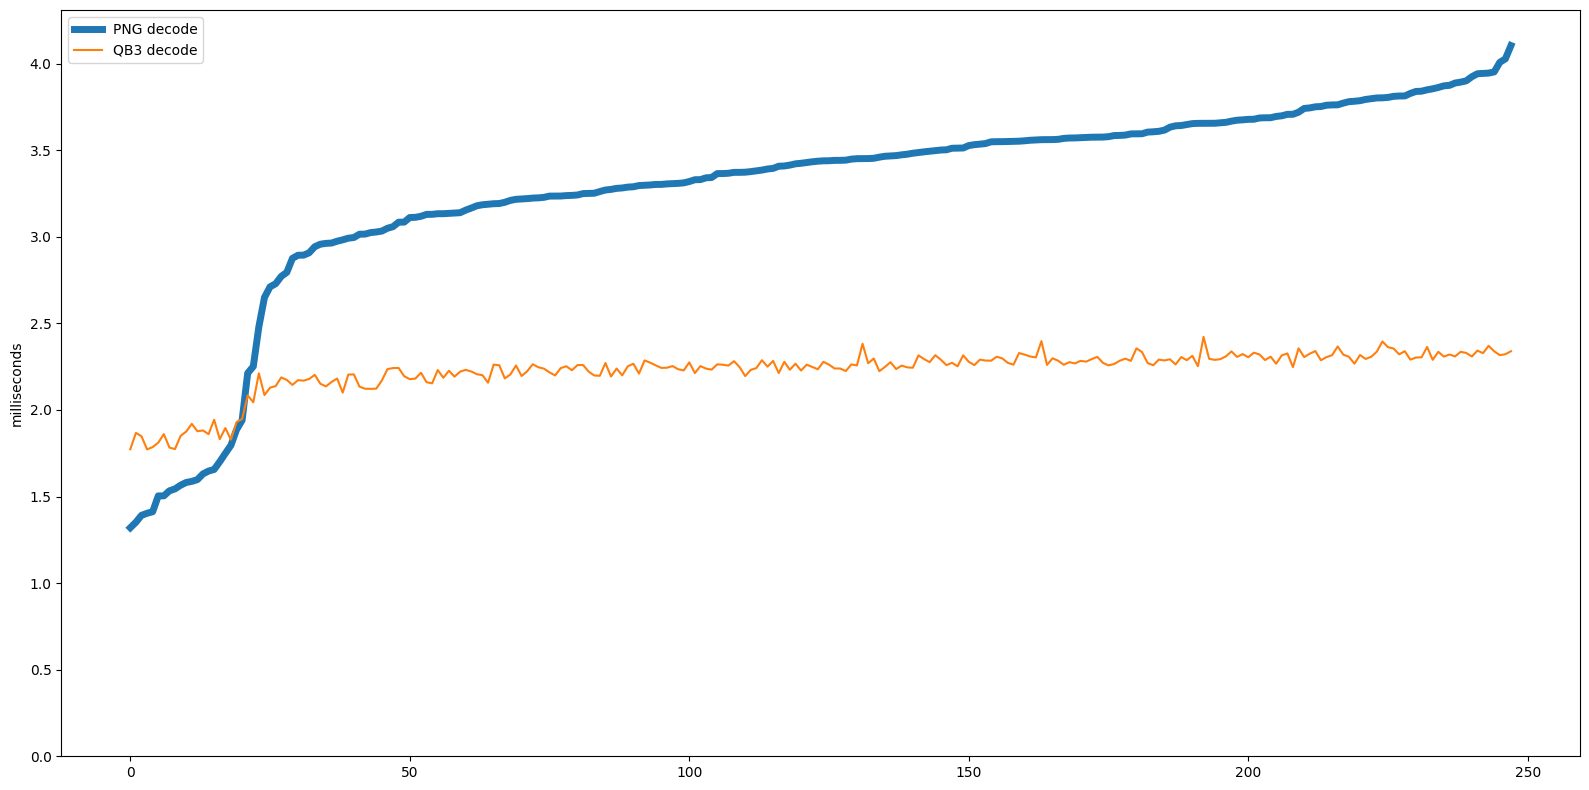

PNG decode:
 max 4.10ms,  191.58 MB/s
 avg 3.27ms, 240.17 MB/s
 min 1.32ms,  595.83 MB/s
QB3 decode:
 max 2.42ms,  324.69 MB/s
 avg 2.23ms, 353.33 MB/s
 min 1.77ms,  443.69 MB/s


In [33]:
# Start another plot, for decoding speed vs PNG
# zip the png_decode and qb3_decode
data = list(zip(png_decode, qb3_decode))
# Convert to ms
data = [[1000*x for x in y] for y in data]

# Sort by PNG decode time
data = sorted(data, key=lambda x: x[0])

# Transpose the data
data = list(zip(*data))
# Start a plot
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)

# Create a plot
index = range(len(data[0]))
# Unpack by columns
png_decode, qb3_decode = data

# Line with 1
thick = 5

line_pngdecode = plt.plot(index, png_decode, label="PNG decode", linewidth=thick)
line_qb3decode = plt.plot(index, qb3_decode, label="QB3 decode")
# y axis starts at 0, to show the relative difference
plt.ylim(0, max(max(png_decode), max(qb3_decode)) * 1.05)
plt.legend(loc='upper left')
plt.ylabel("milliseconds")
# Tight
plt.tight_layout()
plt.show()

# Save the figure as svg
fig.savefig("CID22_decode.svg")

# Get stats
averages = [sum(x)/len(x) for x in data]
maxs = [max(x) for x in data]
mins = [min(x) for x in data]
# The times are in ms, so we only need to divide by 1e3 to get MB/sec
RAW_SIZE = 512 * 512 * 3 / 1e3

for i in range(2):
    print(f"{['PNG', 'QB3'][i]} decode:")
    print(f" max {maxs[i]:1.2f}ms,  {RAW_SIZE/maxs[i]:1.2f} MB/s")
    print(f" avg {averages[i]:1.2f}ms, {RAW_SIZE/averages[i]:1.2f} MB/s")
    print(f" min {mins[i]:1.2f}ms,  {RAW_SIZE/mins[i]:1.2f} MB/s")